In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import scipy.interpolate
from corner import corner
import GPy
import sys
from time import time
from corner import hist2d

sys.path.append('../')
import delight
from delight.hmc import HMC
from delight.utils import approx_DL
from delight.photoz_gp import PhotozGP

In [2]:
max_redshift = 2.0
survey = 'DES'
ab_filters = np.array(['g', 'r', 'i', 'z', 'Y'])
numBands = len(ab_filters)
amp_arr = np.genfromtxt('./data/'+survey+'_filter_gaussian_coefficients_amp_'+''.join(ab_filters)+'.txt')
mu_arr = np.genfromtxt('./data/'+survey+'_filter_gaussian_coefficients_mu_'+''.join(ab_filters)+'.txt')
sig_arr = np.genfromtxt('./data/'+survey+'_filter_gaussian_coefficients_sig_'+''.join(ab_filters)+'.txt')
nb, numCoefs = mu_arr.shape
        
numtemplates = 8
f_mod = np.load('./data/CWW_redshiftgrid_zmax'+str(max_redshift)+'_'+survey+'_'+''.join(ab_filters)+'.npy')[:,:numtemplates,:]
f_mod2 = np.load('./data/CWW_redshiftgrid_zmax'+str(max_redshift)+'_'+survey+'_'+''.join(ab_filters)+'_nolines.npy')[:,:numtemplates,:]

f_mod3 = np.zeros_like(f_mod)
nz, nt, nf = f_mod.shape
redshiftGrid = np.linspace(0, max_redshift, num=nz)
#ts = np.array([8.33e-02, 2.13e-01, 3.49e-01, 4.47e-01, 3.77e-01, 5.22e-01, 7.10e-01, 1.00e+00])[:numtemplates]
#ts -= np.min(ts)
#ts /= np.max(ts)
#ind = ts.argsort()
#ts = ts[ind]
#f_mod = f_mod[:,ind,:]
#f_mod2 = f_mod2[:,ind,:]

ts = np.linspace(0, 1, num=nt)
coefs1 = np.array([-0.00177522929007, 0.5653, 0.000186441821799, 9.57259])
coefs2 = np.array([-0.000354784639976, 4.30089, 0.000227322055552, 0.46153])
lambdaRef = 4.5e3

oneplusz = 1. + redshiftGrid
norms = np.sqrt(2*np.pi) * np.sum(amp_arr * sig_arr, axis=1)
DL = approx_DL()
for it in range(nt):
    for jf in range(nf):
        for i in range(numCoefs):
            amp, mu, sig = amp_arr[jf, i], mu_arr[jf, i], sig_arr[jf, i]
            lambdaMin = mu - 5*sig
            lambdaMax = mu + 5*sig
            xf = np.linspace(lambdaMin, lambdaMax, num=200)
            yf = amp * np.exp(-0.5*((xf-mu)/sig)**2)
            for iz, z in enumerate(redshiftGrid):
                xfz = xf / oneplusz[iz]
                alpha = 0*xfz
                alpha[xfz<lambdaRef] = coefs1[0] * (1 - ts[it]**coefs1[1]) + coefs1[2] * ts[it]**coefs1[3]
                alpha[xfz>=lambdaRef] = coefs2[0] * (1 - ts[it]**coefs2[1]) + coefs2[2] * ts[it]**coefs2[3]
                sed = np.exp(-alpha*(xfz - lambdaRef))
                f_mod3[iz,it,jf] += np.trapz(sed*yf, x=xf) / norms[jf] #* oneplusz[iz]**2.


f_mod_interps = np.zeros((nt, nf), dtype=object)
f_mod_interps2 = np.zeros((nt, nf), dtype=object)
f_mod_interps3 = np.zeros((nt, nf), dtype=object)
for jf in range(nf):    
    for it in range(nt):
        f_mod[:,it,jf] = oneplusz / DL(redshiftGrid)**2 / (4*np.pi) * f_mod[:,it,jf] 
        f_mod2[:,it,jf] = oneplusz / DL(redshiftGrid)**2 / (4*np.pi) * f_mod2[:,it,jf]  
        f_mod3[:,it,jf] = oneplusz / DL(redshiftGrid)**2 / (4*np.pi) * f_mod3[:,it,jf]  
        
for jf in range(nf):                            
    for it in range(nt):
        f_mod_interps[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod[:,it,jf], kind='cubic')
        f_mod_interps2[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod2[:,it,jf], kind='cubic')
        f_mod_interps3[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod3[:,it,jf], kind='cubic')

In [3]:
bandsUsed = np.arange(4).astype(int)
bands = ab_filters[bandsUsed]
numrandomdata = 500
if True:
    data_all = pd.read_csv('/Users/bl/Dropbox/WL_drop/train_sns_main_deep_2.3.csv')#, delimiter=',', header=True)#, max_rows=1e5)
    ind = reduce(np.logical_and, [data_all['mag_auto_'+b] > 19 for b in bands])
    ind &= reduce(np.logical_and, [data_all['magerr_auto_'+b] < 0.05 for b in bands])
    data_all = data_all[ind]
    ind = np.random.choice(data_all.shape[0], numrandomdata, replace=False)
    data = data_all.iloc[ind]
    z_cols = [col for col in data.columns if 'z_spec' in col]
else:
    names = ['mag_auto_'+b for b in bands] + ['magerr_auto_'+b for b in bands] + ['z_spec_0']
    data_all = pd.read_csv('/Users/bl/Dropbox/bnz/bbcufigsubsample/bccufig_subsample_matchedngmixcolours_extracuts_autoerrz.txt', names=names, sep=' ')#, delimiter=',', header=True)#, max_rows=1e5)
    ind = reduce(np.logical_and, [data_all['magerr_auto_'+b] < 0.05 for b in bands])
    data_all = data_all[ind]
    ind = np.random.choice(data_all.shape[0], numrandomdata, replace=False)
    data = data_all.iloc[ind]
    z_cols = [col for col in data.columns if 'z_spec' in col]
#data[z_cols].describe()
data.describe()

 /Users/bl/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning:Columns (26,32,36,40,45,49,53) have mixed types. Specify dtype option on import or set low_memory=False.


,coadd_objects_id,ra,dec,mag_auto_g,magerr_auto_g,mag_detmodel_g,magerr_detmodel_g,mag_auto_r,magerr_auto_r,mag_detmodel_r,...,draw_mag_auto_z,draw_mag_detmodel_g,draw_mag_detmodel_r,draw_mag_detmodel_i,draw_mag_detmodel_z,new,im3shape_weights,weight_selection,ngmix_weights,bench_weights
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.933915e+09,80.783956,-7.125521,22.189053,0.022695,22.210409,0.015017,21.355263,0.011358,21.360640,...,20.695421,22.208990,21.360595,20.921785,20.687605,1.036000,0.000039,0.982000,0.000028,0.000042
std,7.718966e+06,53.005580,11.580936,1.037700,0.012804,1.040923,0.009294,1.051464,0.007340,1.044616,...,1.051381,1.040727,1.044465,1.037962,1.051581,0.186477,0.000032,0.133084,0.000024,0.000041
min,2.924582e+09,7.085475,-44.437703,19.271300,0.002200,19.280600,0.001500,19.182200,0.001400,19.187500,...,19.003061,19.280582,19.186411,18.279375,18.936119,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.925255e+09,36.312188,-5.596287,21.471959,0.011100,21.504427,0.006900,20.501591,0.005475,20.518579,...,19.769878,21.491909,20.519307,20.027460,19.755525,1.000000,0.000015,1.000000,0.000011,0.000016
50%,2.938110e+09,53.049691,-4.467920,22.371412,0.022050,22.414865,0.014300,21.410133,0.010300,21.418586,...,20.660354,22.412070,21.418586,20.909027,20.662606,1.000000,0.000033,1.000000,0.000023,0.000033
75%,2.939033e+09,149.917562,1.999100,23.020493,0.032300,23.031423,0.021700,22.184980,0.015725,22.229332,...,21.605687,23.031423,22.228918,21.794890,21.585308,1.000000,0.000055,1.000000,0.000039,0.000054
max,2.970584e+09,151.140557,2.845229,23.929653,0.049800,24.053759,0.068900,23.455718,0.047500,23.409386,...,22.847113,24.053759,23.409386,23.267660,22.884341,2.000000,0.000317,1.000000,0.000256,0.000402


In [4]:
magerrmin = 0.01
ZP = - 14
numBandsUsed = len(bandsUsed)
typesUsed = np.arange(nt) 
numTypesUsed = len(typesUsed)
tmax = float(np.max(nt) - 1)
numpoints = data.shape[0]
Yvar = np.zeros((numpoints, numBandsUsed))
Ystd = np.zeros((numpoints, numBandsUsed))
Y = np.zeros((numpoints, numBandsUsed))
redshifts = data['z_spec_0'].as_matrix().reshape((-1, 1))
for ib, b in enumerate(bandsUsed):
    bnm = ab_filters[b]
    Y[:, ib] = 10**(-0.4*(data['mag_auto_'+bnm] + ZP))
    magerr = data['magerr_auto_'+bnm].as_matrix()
    magerr[magerr < magerrmin] = magerrmin
    Ystd[:, ib] = (10.**(.4*magerr)-1.) * Y[:, ib]
    Yvar[:, ib] = Ystd[:, ib]**2.

In [5]:
type_estimates = np.zeros_like(redshifts)
luminosity_estimates = np.zeros_like(redshifts)
chi2s = np.zeros_like(redshifts)
for o in range(Y.shape[0]):
    chi2 = np.zeros((nt,))
    z = redshifts[o]
    for t in range(nt):
        for ib in range(numBandsUsed-1):
            b1 = bandsUsed[ib]
            b2 = bandsUsed[ib+1]
            v_mod = (f_mod_interps[t,b1](z) / f_mod_interps[t,b2](z))
            v_dat = Y[o,ib] / Y[o,ib+1]
            var = v_dat**2 * (Yvar[o,ib]/Y[o,ib]**2 + Yvar[o,ib+1]/Y[o,ib+1]**2)
            #print v_mod, v_dat, var
            chi2[t] += -0.5*(v_dat - v_mod)**2/var - np.sqrt(var)
    t = np.argmax(chi2)
    type_estimates[o,0] = ts[t]
    
    for ib in range(numBandsUsed):
        b1 = bandsUsed[ib].astype(int)
        v_mod = f_mod_interps[t,b1](z)[0] 
        v_dat = Y[o,ib]
        luminosity_estimates[o,0] += (v_dat/v_mod) / numBandsUsed
        
    for ib in range(numBandsUsed):
        b1 = bandsUsed[ib].astype(int)
        v_mod = f_mod_interps[t,b1](z)[0] 
        chi2s[o,0] += 0.5*(luminosity_estimates[o,0]*v_mod - Y[o,ib])**2/Yvar[o,ib] / numBandsUsed
    #print type_estimates[o,0], luminosity_estimates[o,0]

chi2lim = 1.0
for t in typesUsed:
    ind = np.where(type_estimates[:,0] == ts[t])[0]
    if ind.size > 0:
        i = np.argmin(chi2s[ind,0])
        chi2s[ind[i],0] = chi2lim
        
unfixed_indices = np.where(chi2s > chi2lim)[0]
fixed_indices = np.where(chi2s <= chi2lim)[0]

0.70838037313 0.533787840711


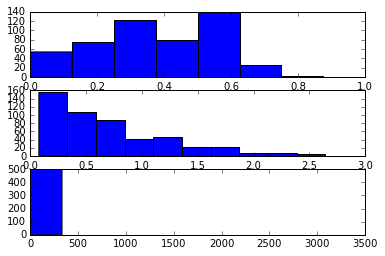

In [6]:
fig, axs = plt.subplots(3, 1)
axs[0].hist(type_estimates, nt, range=[0, 1])
axs[1].hist(luminosity_estimates)
axs[2].hist(chi2s)
print np.mean(luminosity_estimates), np.std(luminosity_estimates)
#axs[1].set_xscale('log')

467 33 500


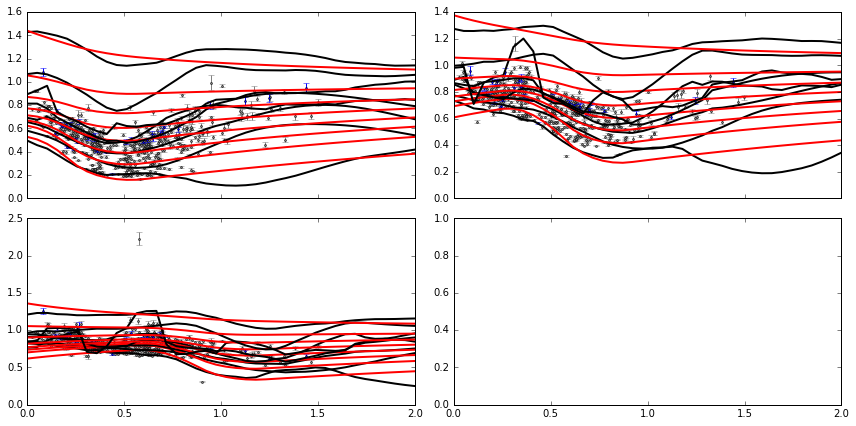

In [7]:
print unfixed_indices.size, fixed_indices.size, chi2s.size

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=False)
axs =axs.ravel()
for ib in range(numBandsUsed-1):
    b1 = bandsUsed[ib]
    b2 = bandsUsed[ib+1]
    v_dat = Y[:,ib] / Y[:,ib+1]
    var = v_dat**2 * (Yvar[:,ib]/Y[:,ib]**2 + Yvar[:,ib+1]/Y[:,ib+1]**2)
    axs[ib].errorbar(redshifts[unfixed_indices], v_dat[unfixed_indices], yerr=np.sqrt(var[unfixed_indices]), 
                     fmt='o', color='gray', markersize=2)
    axs[ib].errorbar(redshifts[fixed_indices], v_dat[fixed_indices], yerr=np.sqrt(var[fixed_indices]), 
                     fmt='o', color='b', markersize=2)
      
for t in typesUsed:
    for ib in range(numBandsUsed-1):
        axs[ib].plot(redshiftGrid, f_mod[:,t,ib]/f_mod[:,t,ib+1], ls='solid', lw=2, c='k')
        axs[ib].plot(redshiftGrid, f_mod3[:,t,ib]/f_mod3[:,t,ib+1], ls='solid', lw=2, c='r')
            
fig.tight_layout()

Type 0  :  1 fixed,  53 unfixed
Type 1  :  2 fixed,  74 unfixed
Type 2  :  5 fixed,  117 unfixed
Type 3  :  4 fixed,  75 unfixed
Type 4  :  16 fixed,  124 unfixed
Type 5  :  4 fixed,  22 unfixed
Type 6  :  1 fixed,  2 unfixed
Type 7  :  0 fixed,  0 unfixed


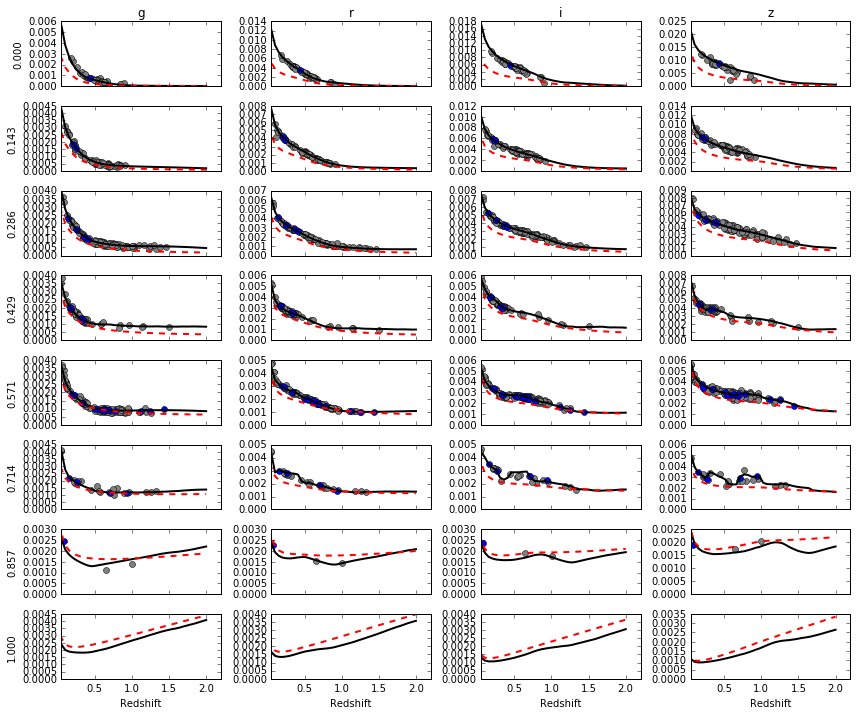

In [8]:
fig, axs = plt.subplots(nt, numBandsUsed, figsize=(12, 10), sharex=True, sharey=False)
for t in typesUsed: 
    ind = (type_estimates == ts[t]).ravel()
    ind1 = np.logical_and(ind, chi2s.ravel() <= chi2lim)
    ind2 = np.logical_and(ind, chi2s.ravel() > chi2lim)
    print 'Type', t, ' : ', ind1.sum(), 'fixed, ', ind2.sum(), 'unfixed'
    for ib in range(numBandsUsed):
        b1 = bandsUsed[ib].astype(int) 
        l = luminosity_estimates[ind2,0]
        axs[t,b1].errorbar(redshifts[ind2], Y[ind2,ib]/l, yerr=Ystd[ind2,ib]/l, fmt='o', c='gray', markersize=6)
        l = luminosity_estimates[ind1,0]
        axs[t,b1].errorbar(redshifts[ind1], Y[ind1,ib]/l, yerr=Ystd[ind1,ib]/l, fmt='o', c='b', markersize=6)
        
    for jf in bandsUsed:
        axs[t,jf].plot(redshiftGrid, f_mod[:,t,jf], ls='solid', lw=2, c='k')
        #axs[t,jf].plot(redshiftGrid, f_mod2[:,t,jf], ls='solid', lw=2, c='b')
        axs[t,jf].plot(redshiftGrid, f_mod3[:,t,jf], ls='dashed', lw=2, c='r')
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if t == nt-1:
            axs[t,jf].set_xlabel('Redshift')
            axs[t,jf].set_xlim([0.05, max_redshift*1.1])
        if jf == 0:
            axs[t,jf].set_ylabel('%.3f' % ts[t]) # template_names[t])
            
fig.tight_layout()

In [9]:
alpha_C = 1e3
alpha_L = 1e1
alpha_T = 1./numtemplates
var_C = 0.5
var_L = 1e4
extranoise = 1e-7
redshiftGridInterp = np.linspace(np.min(redshifts), 2, num=20)
typeBinsize = 0.1
types_inducing = np.arange(0, 1.01, typeBinsize)
print types_inducing
xv, yv, zv = np.meshgrid(bandsUsed, redshiftGridInterp, types_inducing, sparse=False, indexing='xy')
nInducing = xv.size
X_inducing = np.ones((nInducing, 4))
X_inducing[:, 0] = xv.flatten()
X_inducing[:, 1] = yv.flatten()
X_inducing[:, 3] = zv.flatten()
print X_inducing.shape

lines_mu = np.array([ 6500, 5002.26, 3732.22])
lines_sig = np.array([ 20.0, 34.10, 23.11])

type_estimates[type_estimates <= 0] = 0.01
type_estimates[type_estimates >= 1] = 0.99
gp = PhotozGP(
    redshifts, luminosity_estimates, type_estimates, unfixed_indices,
    Y, Yvar, extranoise, bandsUsed,
    amp_arr, mu_arr, sig_arr,
    lines_mu, lines_sig,
    var_C, var_L,
    alpha_C, alpha_L, alpha_T,
    prior_z_t=None,
    prior_ell_t=None,
    prior_t=None,
    X_inducing=X_inducing,
    redshiftGrid=redshiftGridInterp,
    use_interpolators=True
    )

gp.extranoise.fix()#.constrain_bounded(1e-9, 1e-8)
gp.kern.var_C.constrain_bounded(0.3, 1.0)#constrain_positive()
gp.kern.var_L.constrain_bounded(5e4, 1e6)#constrain_positive()
gp.kern.alpha_T.constrain_bounded(0.25/numtemplates, 4./numtemplates)
gp.kern.alpha_C.fix()#.constrain_bounded(1e3, 1e4)
gp.kern.alpha_L.fix()#.constrain_bounded(1e1, 1e3)
gp.unfixed_redshifts.fix()

gp.unfixed_types.constrain_bounded(0, 1)
gp.unfixed_luminosities.constrain_bounded(0, 30)

#gp.optimize('bfgs', messages=True)
best_fit_parameters = gp.optimizer_array.copy()

truthdict = {'photoz_kern.var_C': var_C, 'photoz_kern.var_L': var_L, 
             'photoz_kern.alpha_C': alpha_C, 'photoz_kern.alpha_T': alpha_T}
for i, (l, z, t) in enumerate(zip(luminosity_estimates, redshifts, type_estimates)):
    ich = str(i)
    if i > 9:
        ich += ' '
    if i > 99:
        ich += ' '
    if i > 999:
        ich += ' '
    truthdict['luminosities[['+ich+' 0]]'] = l[0]
    truthdict['redshifts[['+ich+' 0]]'] = z[0]
    truthdict['types[['+ich+' 0]]'] = t[0]

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
(880, 4)


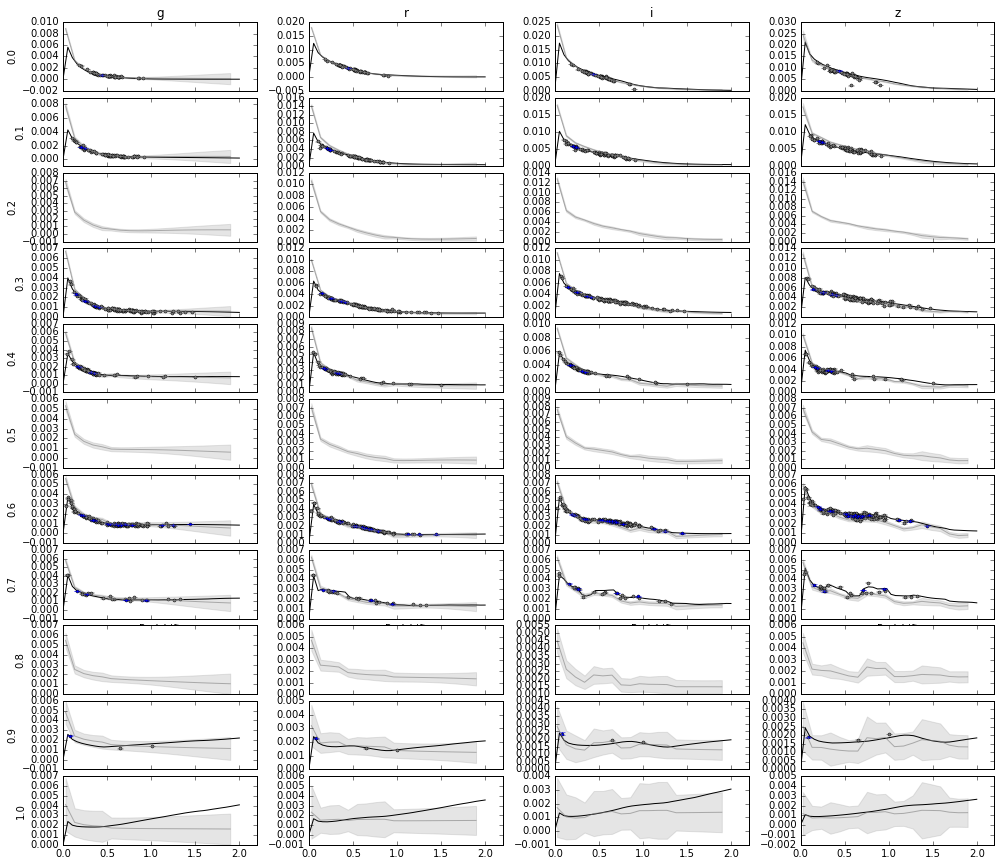

In [10]:
fig, axs = plt.subplots(types_inducing.size, numBandsUsed, 
                        figsize=(14, 1.1*types_inducing.size), sharex=True, sharey=False)
for it, t in enumerate(types_inducing):
    for jf in bandsUsed:
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if it == nt-1:
            axs[it,jf].set_xlabel('Redshift')
            axs[it,jf].set_xlim([0, max_redshift*1.1])
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if jf == 0:
            axs[it,jf].set_ylabel(t) # template_names[t])
            
    for itm in range(nt):
        if ts[itm] < t + typeBinsize/2 and ts[itm] >= t - typeBinsize/2:
            for jf in bandsUsed:
                axs[it,jf].plot(redshiftGrid, f_mod[:,itm,jf], ls='solid', lw=1, c='k')
                #axs[t,jf].plot(redshiftGrid, f_mod2[:,t,jf], ls='solid', lw=2, c='b')
                #axs[t,jf].plot(redshiftGrid, f_mod3[:,t,jf], ls='solid', lw=2, c='r')
        
    thetypes = gp.types.ravel()
    ind = np.logical_and(thetypes < t + typeBinsize/2, thetypes >= t - typeBinsize/2)
    ind1 = np.logical_and(ind, chi2s.ravel() <= chi2lim)
    ind2 = np.logical_and(ind, chi2s.ravel() > chi2lim)
    #print 'Type', t, ' : ', ind1.sum(), 'fixed, ', ind2.sum(), 'unfixed'
    for ib, jf in enumerate(bandsUsed):
        b1 = bandsUsed[ib].astype(int) 
        l = gp.luminosities[ind2,0]
        axs[it,b1].errorbar(redshifts[ind2], Y[ind2,ib]/l, yerr=Ystd[ind2,ib]/l, fmt='o', c='gray', markersize=3)
        l = gp.luminosities[ind1,0]
        axs[it,b1].errorbar(redshifts[ind1], Y[ind1,ib]/l, yerr=Ystd[ind1,ib]/l, fmt='o', c='b', markersize=3)

        ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
        m = gp.Y_inducing_mean[ind,0][:-1]
        s = gp.Y_inducing_std[ind,0][:-1]
        axs[it,jf].plot(redshiftGridInterp[:-1], m, color='gray', alpha=0.6)
        axs[it,jf].fill_between(redshiftGridInterp[:-1], m-s, m+s, color='gray', alpha=0.2)
        #axs[it,jf].set_ylim([0, 7e-3])
        
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

In [11]:
print - gp.log_likelihood()
for itr in range(1):
    ff_mod = np.zeros((Y.shape[0], types_inducing.size, Y.shape[1]))
    ff_mod_err = np.zeros_like(ff_mod)
    for it, t in enumerate(types_inducing):
        for ib, jf in enumerate(bandsUsed):
            ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
            ff_mod[:, it, ib] = np.interp(redshifts[:,0], redshiftGridInterp, gp.Y_inducing_mean[ind,0])
            ff_mod_err[:, it, ib] = np.interp(redshifts[:,0], redshiftGridInterp, gp.Y_inducing_std[ind,0])

    if False:
        ff_obs_inverrsq = 1 / (Yvar[:, None, :] + ff_mod_err[:, :, :]**2.)
        FOT = np.sum(ff_mod * Y[:, None, :] * ff_obs_inverrsq, axis=(2))
        FTT = np.sum(ff_mod**2.0 * ff_obs_inverrsq, axis=(2))
        FOO = np.sum(Y[:, None, :]**2.0 * ff_obs_inverrsq, axis=(2))
        chi2 = FOO - FOT**2.0 / FTT 
        like = np.exp(-0.5*chi2) / np.sqrt(FTT) # nz * nt
        typesint = np.argmax(like, axis=1)
        type_estimates_new = types_inducing[typesint][:, None]
        luminosity_estimates_new = np.zeros_like(type_estimates, dtype=float)
        for o, t in enumerate(typesint):
            for ib, jf in enumerate(bandsUsed):
                luminosity_estimates_new[o, 0] += (Y[o, ib]/ff_mod[o, t, ib]) / numBandsUsed
        
    type_estimates_new = np.zeros_like(redshifts)
    luminosity_estimates_new = np.zeros_like(redshifts)
    chi2s_new = np.zeros_like(redshifts)
    for o in range(Y.shape[0]):
        chi2 = np.zeros((types_inducing.size,))
        z = redshifts[o]
        for t in range(types_inducing.size):
            for ib in range(numBandsUsed-1):
                v_mod = ff_mod[o, t, ib] / ff_mod[o, t, ib+1]
                v_dat = Y[o,ib] / Y[o,ib+1]
                var = v_dat**2 * ((Yvar[o,ib])/Y[o,ib]**2 + (Yvar[o,ib+1])/Y[o,ib+1]**2)
                chi2[t] += -0.5*(v_dat - v_mod)**2/var - np.sqrt(var)
        t = np.argmax(chi2)
        type_estimates_new[o,0] = types_inducing[t]
        for ib in range(numBandsUsed):
            luminosity_estimates_new[o,0] += (Y[o,ib]/ff_mod[o, t, ib]) / numBandsUsed
        for ib in range(numBandsUsed):
            var = Yvar[o,ib]
            chi2s_new[o,0] += 0.5*(luminosity_estimates_new[o,0]*ff_mod[o, t, ib] - Y[o,ib])**2/var / numBandsUsed

    #chi2lim = 0.5
    #unfixed_indices = np.where(chi2s_new > chi2lim)[0]
    #fixed_indices = np.where(chi2s_new <= chi2lim)[0]
            
    gp.update_model(False)
    gp.luminosities[:] = luminosity_estimates_new[:]
    gp.unfixed_luminosities.values[:, 0]\
        = luminosity_estimates_new[gp.unfixed_indices, 0]
    gp.types[:] = type_estimates_new[:]
    gp.unfixed_types.values[:, 0]\
        = type_estimates_new[gp.unfixed_indices, 0]
    gp.update_model(True)
    gp.parameters_changed()
    print - gp.log_likelihood()

-13216.8610514
-13638.0023557


(array([ 107.,   67.,  131.,   61.,   81.,   42.,    9.,    2.]),
 array([ 0.    ,  0.1125,  0.225 ,  0.3375,  0.45  ,  0.5625,  0.675 ,
         0.7875,  0.9   ]),
 <a list of 8 Patch objects>)

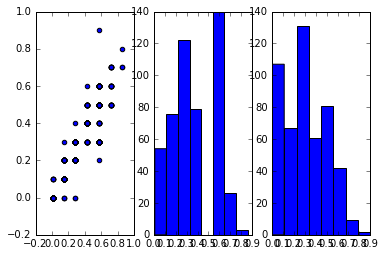

In [12]:
fig, axs = plt.subplots(1, 3)
axs[0].scatter(type_estimates, type_estimates_new)
axs[1].hist(type_estimates, bins=nt)
axs[2].hist(type_estimates_new, bins=nt)

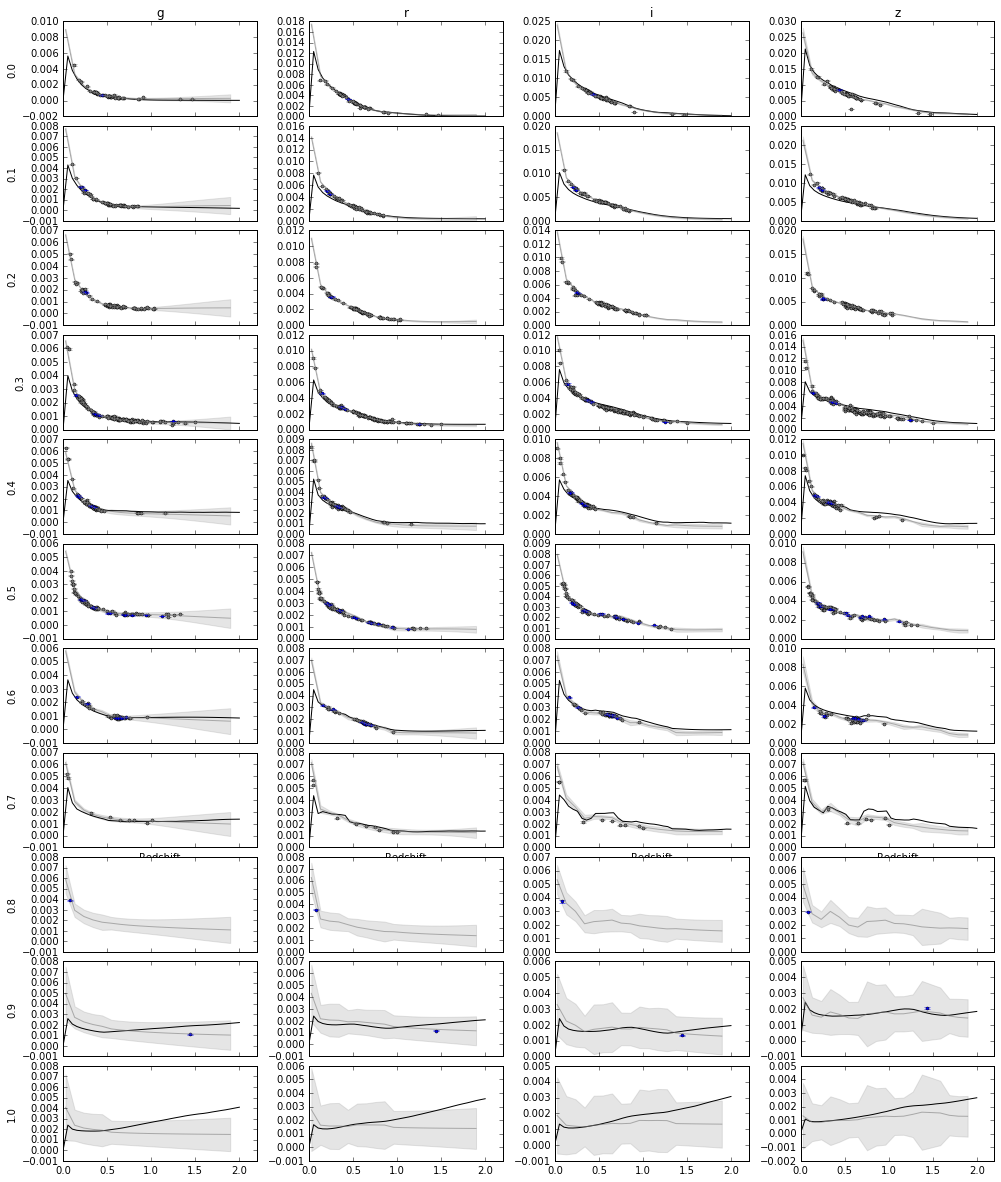

In [ ]:
fig, axs = plt.subplots(types_inducing.size, numBandsUsed, 
                        figsize=(14, 1.5*types_inducing.size), sharex=True, sharey=False)
for it, t in enumerate(types_inducing):
    for jf in bandsUsed:
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if it == nt-1:
            axs[it,jf].set_xlabel('Redshift')
            axs[it,jf].set_xlim([0, max_redshift*1.1])
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if jf == 0:
            axs[it,jf].set_ylabel(t) # template_names[t])
            
    for itm in range(nt):
        if ts[itm] < t + typeBinsize/2 and ts[itm] >= t - typeBinsize/2:
            for jf in bandsUsed:
                axs[it,jf].plot(redshiftGrid, f_mod[:,itm,jf], ls='solid', lw=1, c='k')
                #axs[t,jf].plot(redshiftGrid, f_mod2[:,t,jf], ls='solid', lw=2, c='b')
                #axs[t,jf].plot(redshiftGrid, f_mod3[:,t,jf], ls='solid', lw=2, c='r')
        
    thetypes = gp.types.ravel()
    ind = np.logical_and(thetypes < t + typeBinsize/2, thetypes >= t - typeBinsize/2)
    ind1 = np.logical_and(ind, chi2s.ravel() <= chi2lim)
    ind2 = np.logical_and(ind, chi2s.ravel() > chi2lim)
    #print 'Type', t, ' : ', ind1.sum(), 'fixed, ', ind2.sum(), 'unfixed'
    for ib, jf in enumerate(bandsUsed):
        b1 = bandsUsed[ib].astype(int) 
        l = gp.luminosities[ind2,0]
        axs[it,b1].errorbar(redshifts[ind2], Y[ind2,ib]/l, yerr=Ystd[ind2,ib]/l, fmt='o', c='gray', markersize=3)
        l = gp.luminosities[ind1,0]
        axs[it,b1].errorbar(redshifts[ind1], Y[ind1,ib]/l, yerr=Ystd[ind1,ib]/l, fmt='o', c='b', markersize=3)

        ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
        m = gp.Y_inducing_mean[ind,0][:-1]
        s = gp.Y_inducing_std[ind,0][:-1]
        axs[it,jf].plot(redshiftGridInterp[:-1], m, color='gray', alpha=0.6)
        axs[it,jf].fill_between(redshiftGridInterp[:-1], m-s, m+s, color='gray', alpha=0.2)
        #axs[it,jf].set_ylim([0, 7e-3])
            
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

In [ ]:
gp.optimize('bfgs', messages=True)
print - gp.log_likelihood()

In [ ]:
fig, axs = plt.subplots(types_inducing.size, numBandsUsed, 
                        figsize=(14, 1.5*types_inducing.size), sharex=True, sharey=False)
for it, t in enumerate(types_inducing):
    for jf in bandsUsed:
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if it == nt-1:
            axs[it,jf].set_xlabel('Redshift')
            axs[it,jf].set_xlim([0, max_redshift*1.1])
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if jf == 0:
            axs[it,jf].set_ylabel(t) # template_names[t])
            
    for itm in range(nt):
        if ts[itm] < t + typeBinsize/2 and ts[itm] >= t - typeBinsize/2:
            for jf in bandsUsed:
                axs[it,jf].plot(redshiftGrid, f_mod[:,itm,jf], ls='solid', lw=1, c='k')
                #axs[t,jf].plot(redshiftGrid, f_mod2[:,t,jf], ls='solid', lw=2, c='b')
                #axs[t,jf].plot(redshiftGrid, f_mod3[:,t,jf], ls='solid', lw=2, c='r')
        
    thetypes = gp.types.ravel()
    ind = np.logical_and(thetypes < t + typeBinsize/2, thetypes >= t - typeBinsize/2)
    ind1 = np.logical_and(ind, chi2s.ravel() <= chi2lim)
    ind2 = np.logical_and(ind, chi2s.ravel() > chi2lim)
    #print 'Type', t, ' : ', ind1.sum(), 'fixed, ', ind2.sum(), 'unfixed'
    for ib, jf in enumerate(bandsUsed):
        b1 = bandsUsed[ib].astype(int) 
        l = gp.luminosities[ind2,0]
        axs[it,b1].errorbar(redshifts[ind2], Y[ind2,ib]/l, yerr=Ystd[ind2,ib]/l, fmt='o', c='gray', markersize=3)
        l = gp.luminosities[ind1,0]
        axs[it,b1].errorbar(redshifts[ind1], Y[ind1,ib]/l, yerr=Ystd[ind1,ib]/l, fmt='o', c='b', markersize=3)

        ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
        m = gp.Y_inducing_mean[ind,0][:-1]
        s = gp.Y_inducing_std[ind,0][:-1]
        axs[it,jf].plot(redshiftGridInterp[:-1], m, color='gray', alpha=0.6)
        axs[it,jf].fill_between(redshiftGridInterp[:-1], m-s, m+s, color='gray', alpha=0.2)
        #axs[it,jf].set_ylim([0, 7e-3]) 
            
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

In [ ]:
fig, axs = plt.subplots(types_inducing.size, numBandsUsed, 
                        figsize=(14, 1.5*types_inducing.size), sharex=True, sharey=False)
for it, t in enumerate(types_inducing):
    for jf in bandsUsed:
        axs[it,jf].set_xlim([0, 1.2])
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if it == nt-1:
            axs[it,jf].set_xlabel('Redshift')
            axs[it,jf].set_xlim([0, max_redshift*1.1])
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if jf == 0:
            axs[it,jf].set_ylabel(t) # template_names[t])
        
    thetypes = gp.types.ravel()
    ind = np.logical_and(thetypes < t + typeBinsize/2, thetypes >= t - typeBinsize/2)
    ind1 = np.logical_and(ind, chi2s.ravel() <= chi2lim)
    ind2 = np.logical_and(ind, chi2s.ravel() > chi2lim)
    #print 'Type', t, ' : ', ind1.sum(), 'fixed, ', ind2.sum(), 'unfixed'
    for ib, jf in enumerate(bandsUsed):
        ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
        m = gp.Y_inducing_mean[ind,0][:-1]
        s = gp.Y_inducing_std[ind,0][:-1]
        intrp = scipy.interpolate.interp1d(redshiftGridInterp[:-1], m)
        axs[it,jf].plot(redshiftGridInterp[:-1], m*0, color='gray', alpha=0.6)
        axs[it,jf].fill_between(redshiftGridInterp[:-1], -s, +s, color='gray', alpha=0.2)
        b1 = bandsUsed[ib].astype(int) 
        l = gp.luminosities[ind2,0]
        axs[it,b1].errorbar(redshifts[ind2], Y[ind2,ib]/l-intrp(redshifts[ind2,0]), yerr=Ystd[ind2,ib]/l, fmt='o', c='gray', markersize=3)
        l = gp.luminosities[ind1,0]
        axs[it,b1].errorbar(redshifts[ind1], Y[ind1,ib]/l-intrp(redshifts[ind1,0]), yerr=Ystd[ind1,ib]/l, fmt='o', c='b', markersize=3)
            
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(gp.types, bins=100)
for t in types_inducing:
    ax.axvline(t, ls='dashed')
stop

In [ ]:
num_samples = 1
ntGrid = types_inducing.size
fluxes_mean = np.zeros((nz, ntGrid, nf, num_samples))
for ip in range(num_samples):
    for it, t in enumerate(types_inducing):
        for ib, jf in enumerate(bandsUsed):
            ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
            fluxes_mean[:,it,jf,ip] = np.interp(redshiftGrid, redshiftGridInterp[:-1], gp.Y_inducing_mean[ind,0][:-1])

In [ ]:
def likelihood_aligneduniformgrid(args):
    f_obs, f_obs_err, f_mod = args
    nz, nb_templates, nf = f_mod.shape
    f_obs_inverrsq = np.where(f_obs/f_obs_err<1e-6, 0.0, f_obs_err**-2.0)
    FOT = np.dot(f_mod, f_obs * f_obs_inverrsq) #  nz * nt
    FTT = np.dot(f_mod**2.0, f_obs_inverrsq[:]) # nz * nt
    FOO = np.dot(f_obs[:]**2.0, f_obs_inverrsq[:]) # scalar
    chi2 = FOO - FOT**2.0 / FTT # nz * nt#    chi2 /= chi2.max()
    like = np.exp(-0.5*chi2) / np.sqrt(FTT) # nz * nt
    return like

In [ ]:
numpoints_test = 10000
ind = np.random.choice(data_all.shape[0], numpoints_test, replace=False)
datatest = data_all.iloc[ind]
Ytestvar = np.zeros((numpoints_test, numBandsUsed))
Yteststd = np.zeros((numpoints_test, numBandsUsed))
Ytest = np.zeros((numpoints_test, numBandsUsed))
redshiftstest = datatest['z_spec_0'].as_matrix().reshape((-1, 1))
for ib, b in enumerate(bandsUsed):
    bnm = ab_filters[b]
    Ytest[:, ib] = 10**(-0.4*(datatest['mag_auto_'+bnm] + ZP))
    magerr = datatest['magerr_auto_'+bnm].as_matrix()
    magerr[magerr < magerrmin] = magerrmin
    Yteststd[:, ib] = (10.**(.4*magerr)-1.) * Ytest[:, ib]
    Ytestvar[:, ib] = Yteststd[:, ib]**2.
    
like_gp = np.zeros((numpoints_test, nz, ntGrid))
like_cww = np.zeros((numpoints_test, nz, nt))
for o in range(numpoints_test):
    args = (Ytest[o,:], Yteststd[o,:], fluxes_mean[:,:,bandsUsed,0])
    like_gp[o,:,:] = likelihood_aligneduniformgrid(args)
    args = (Ytest[o,:], Yteststd[o,:], f_mod[:,:,bandsUsed])
    like_cww[o,:,:] = likelihood_aligneduniformgrid(args)
    
zlike_gp = like_gp[:,:,:].sum(axis=2)
zlike_gp /= zlike_gp.max(axis=1)[:,None]
zlike_cww = like_cww[:,:,:].sum(axis=2)
zlike_cww /= zlike_cww.max(axis=1)[:,None]
zml_cww = redshiftGrid[np.argmax(zlike_cww, axis=1)]
zml_gp = redshiftGrid[np.argmax(zlike_gp, axis=1)]
zspec = redshiftstest.ravel()

In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(16, 10))
axs = axs.ravel()
for o in range(axs.size):
    axs[o].plot(redshiftGrid, zlike_cww[o,:], c='gray', lw=2)
    axs[o].plot(redshiftGrid, zlike_gp[o,:], c='b', lw=2)
    axs[o].axvline(redshiftstest[o,0], c='k', ls='dashed', lw=3)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 14))

hist2d(zspec, zml_cww, 30, ax=axs[0,0])
axs[0,0].set_xlim([0, 2])
axs[0,0].set_ylim([0, 2])
axs[0,0].plot(redshiftGrid, redshiftGrid, c='k', ls='dashed')
axs[0,0].set_xlabel('Spectroscopic redshift')
axs[0,0].set_ylabel('ML photometric redshift')
axs[0,0].set_title('Standard template fitting (CWW library)')
hist2d(zspec, zml_gp, 30, ax=axs[0,1])
axs[0,1].set_xlim([0, 2])
axs[0,1].set_ylim([0, 2])
axs[0,1].plot(redshiftGrid, redshiftGrid, c='k', ls='dashed')
axs[0,1].set_xlabel('Spectroscopic redshift')
axs[0,1].set_ylabel('ML photometric redshift')
axs[0,1].set_title('Fitting with continuum GP template sequence')

axs[1,0].scatter(zspec, zml_cww)
axs[1,0].set_xlim([0, 2])
axs[1,0].set_ylim([0, 2])
axs[1,0].plot(redshiftGrid, redshiftGrid, c='k', ls='dashed')
axs[1,1].scatter(zspec, zml_gp)
axs[1,1].set_xlim([0, 2])
axs[1,1].set_ylim([0, 2])
axs[1,1].plot(redshiftGrid, redshiftGrid, c='k', ls='dashed')


axs[2,0].hist(zspec-zml_cww, 50, color='gray', histtype='step', lw=2)
axs[2,0].hist(zspec-zml_gp, 50, color='r', histtype='step', lw=2)
axs[2,0].axvline(0, c='k', ls='dashed', lw=2)
axs[2,1].axvline(0, c='k', ls='dashed', lw=2)
m, s = np.mean(zspec-zml_cww), np.std(zspec-zml_cww)
print m, s
axs[2,1].axvline(m, color='gray', lw=2)
axs[2,1].axvspan(m-s, m+s, color='gray', lw=2, alpha=0.5)
m, s = np.mean(zspec-zml_gp), np.std(zspec-zml_cww)
print m, s
axs[2,1].axvline(m, color='r', lw=2)
axs[2,1].axvspan(m-s, m+s, color='r', lw=2, alpha=0.5)

In [ ]:
nms = gp.parameter_names_flat()
mixingmat = np.eye(nms.size)
for i, nm in enumerate(nms):
    if 'types' in nm:
      mixingmat[i,i] = 1.0  
    if 'luminosities' in nm:
      mixingmat[i,i] = 1.0  
num_samples, hmc_iters = 4, 10
t1 = time()
hmc = HMC(gp, stepsize=1e-4)#, M=mixingmat)
hmc_samples, derived_params = hmc.sample(num_samples=num_samples, hmc_iters=hmc_iters) # TODO: add timing
t2 = time()
print 'Time per HMC iteration: %.4g s' % ((t2-t1)/num_samples)
print 'Number of accepted samples:', len(hmc_samples), 'on', num_samples, ' i.e. %.4g' % (len(hmc_samples)/float(num_samples))
np.set_printoptions(precision=4)
hmc_samples = np.array(hmc_samples)
ind = np.random.randint(low=0, high=hmc_samples.shape[1], size=10)
print np.vstack((hmc_samples.mean(axis=0)[ind], 
                 hmc_samples.std(axis=0)[ind])).T
ind = hmc_samples.std(axis=0) < 1e-12
print 'Number of parameters that didnt move:', np.sum(ind), 'on', hmc_samples.shape[1]

In [ ]:
np.set_printoptions(precision=8)
for params in derived_params:
    print params[0][:4,0]

In [ ]:
import dnest4

class Model(object):
    def __init__(self, model):
        self.model = model
        self.npar = model.parameter_names_flat().size
        self.maxvals = np.ones((self.npar, ))
        for i, nm in enumerate(gp.parameter_names_flat()):
            if 'luminosities' in nm:
                self.maxvals[i] = 30

    def from_prior(self):
        return self.maxvals * np.random.uniform(low=0, high=1, size=self.npar)

    def perturb(self, params):
        which = np.random.randint(self.npar)
        params[which] += self.maxvals[which] * np.random.uniform()
        params[which] = dnest4.wrap(params[which], 0, self.maxvals[which])
        self.model.optimizer_array = 1*params
        return 0.0

    def log_likelihood(self, params):
        return self.model.objective_function()

# Create a model object and a sampler
model = Model(gp)
sampler = dnest4.DNest4Sampler(model,
                               backend=dnest4.backends.CSVBackend(".",
                                                                  sep=" "))

# Set up the sampler. The first argument is max_num_levels
gen = sampler.sample(max_num_levels=30, num_steps=100, new_level_interval=1000,
                      num_per_step=1000, thread_steps=100,
                      num_particles=20, lam=10, beta=100, seed=1234)

# Do the sampling (one iteration here = one particle save)
for i, sample in enumerate(gen):
    print "# Saved {k} particles.".format(k=(i+1)), 

# Run the postprocessing
_ = dnest4.postprocess()

In [ ]:
ny = 6
npar = gp.parameter_names_flat().size
nx = npar / ny + npar % ny
fig, axs = plt.subplots(nx, ny, figsize=(15, nx*1.7))
axs = axs.ravel()
for i, nm in enumerate(gp.parameter_names_flat()):
    axs[i].hist(hmc_samples[:,i], 30, histtype='step')
    axs[i].axvline(truthdict[nm[9:]], c='k')
    axs[i].set_xlabel(nm[9:])
    axs[i].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.5g'))
    #if nm[9] == 't':
    #    axs[i].set_xlim([0, 1])
    #if nm[9] == 'l':
    #    axs[i].set_xlim([0, 10])
fig.tight_layout()
mean_parameters = hmc_samples.mean(axis=0)

In [ ]:
fig, axs = plt.subplots(types_inducing.size, numBandsUsed, 
                        figsize=(14, 1.5*types_inducing.size), sharex=True, sharey=False)
for it, t in enumerate(types_inducing):
    for jf in bandsUsed:
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if t == nt-1:
            axs[t,jf].set_xlabel('Redshift')
            axs[t,jf].set_xlim([0, max_redshift*1.1])
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if jf == 0:
            axs[t,jf].set_ylabel(t) # template_names[t])
        
    for ib, jf in enumerate(bandsUsed):
        ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
        for Y_inducing_mean, Y_inducing_std in derived_params:
            m = Y_inducing_mean[ind,0][:-1]
            s = Y_inducing_std[ind,0][:-1]
            axs[it,jf].plot(redshiftGridInterp[:-1], m, color='gray', alpha=0.6)
            #axs[it,jf].fill_between(redshiftGridInterp[:-1], m-s, m+s, color='gray', alpha=0.2)


In [ ]:
fig, axs = plt.subplots(nt, nf, figsize=(12, 14), sharex=True, sharey=False)
for t in typesUsed:
    for jf in range(nf):
        axs[t,jf].plot(redshiftGrid, f_mod[:,t,jf], ls='solid', lw=2, c='k')
        axs[t,jf].plot(redshiftGrid, f_mod2[:,t,jf], ls='solid', lw=2, c='b')
        #axs[t,jf].plot(redshiftGrid, f_mod3[:,t,jf], ls='solid', lw=2, c='r')
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if t == nt-1:
            axs[t,jf].set_xlabel('Redshift')
            axs[t,jf].set_xlim([0, max_redshift*1.1])
        if jf == 0:
            axs[t,jf].set_ylabel('t'+str(t)) # template_names[t])
        
    ind = (type_estimates == ts[t]).ravel()
    for ib in range(numBandsUsed):
        b1 = bandsUsed[ib].astype(int) 
        l = luminosity_estimates[ind,0]
        axs[t,b1].errorbar(redshifts[ind], Y[ind,ib]/l, yerr=Ystd[ind,ib]/l, fmt='o', markersize=2)
        
for t in typesUsed:
    Xb[:, 3] = ts[t]
    for jf in range(nf):
        Xb[:, 0] = jf
        m = fluxes_mean[t,jf,:,:].mean(axis=1)
        s = np.sqrt(fluxes_var[t,jf,:,:].sum(axis=1))/num_samples
        axs[t,jf].plot(redshiftGrid, m, color='b', alpha=0.6)
        axs[t,jf].fill_between(redshiftGrid, m-s, m+s, color='b', alpha=0.2)
        m = fluxes_samp[t,jf,:,:].mean(axis=1)
        s = fluxes_samp[t,jf,:,:].std(axis=1)
        axs[t,jf].plot(redshiftGrid, m, color='gray', alpha=0.6)
        axs[t,jf].fill_between(redshiftGrid, m-s, m+s, color='gray', alpha=0.2)
            
fig.tight_layout()

In [ ]:
num_samples = hmc_samples.shape[0]
ntGrid = 16
typeGrid = np.linspace(0, 1, num=ntGrid)
fluxes_mean = np.zeros((nz, ntGrid, nf, num_samples))
fluxes_samp = np.zeros((nz, ntGrid, nf, num_samples))
for ip, params in enumerate(hmc_samples[:num_samples]):
    gp.set_unfixed_parameters(params, scalar_params, array_params)
    Xb = np.zeros((redshiftGrid.size, 4))
    Xb[:, 1] = redshiftGrid
    Xb[:, 2] = 1.0
    for it, t in enumerate(typeGrid):
        Xb[:, 3] = t
        for jf in range(nf):
            Xb[:, 0] = jf
            s , var = gp._raw_predict(Xb, full_cov=False)
            fluxes_mean[:,it,jf,ip] = s.flatten()
            fluxes_samp[:,it,jf,ip] = gp.posterior_samples_f(Xb, size=1, full_cov=False).flatten()

In [ ]:
numpoints_test = 1000
ind = np.random.choice(data_all.shape[0], numpoints_test, replace=False)
datatest = data_all.iloc[ind]
Ytestvar = np.zeros((numpoints_test, numBandsUsed))
Yteststd = np.zeros((numpoints_test, numBandsUsed))
Ytest = np.zeros((numpoints_test, numBandsUsed))
redshiftstest = datatest['z_spec_0'].as_matrix().reshape((-1, 1))
for ib, b in enumerate(bandsUsed):
    bnm = ab_filters[b]
    Ytest[:, ib] = 10**(-0.4*(datatest['mag_auto_'+bnm] + ZP))
    magerr = datatest['magerr_auto_'+bnm].as_matrix()
    magerr[magerr < magerrmin] = magerrmin
    Yteststd[:, ib] = (10.**(.4*magerr)-1.) * Ytest[:, ib]
    Ytestvar[:, ib] = Yteststd[:, ib]**2.
    
like_gp = np.zeros((numpoints_test, nz, ntGrid))
like_cww = np.zeros((numpoints_test, nz, nt))
for o in range(numpoints_test):
    for ip in range(num_samples):
        args = (Ytest[o,:], Yteststd[o,:], fluxes_samp[:,:,bandsUsed,ip])
        like_gp[o,:,:] += likelihood_aligneduniformgrid(args)
    args = (Ytest[o,:], Yteststd[o,:], f_mod[:,:,bandsUsed])
    like_cww[o,:,:] = likelihood_aligneduniformgrid(args)
    
zlike_gp = like_gp[:,:,:].sum(axis=2)
zlike_gp /= zlike_gp.max(axis=1)[:,None]
zlike_cww = like_cww[:,:,:].sum(axis=2)
zlike_cww /= zlike_cww.max(axis=1)[:,None]
zml_cww = redshiftGrid[np.argmax(zlike_cww, axis=1)]
zml_gp = redshiftGrid[np.argmax(zlike_gp, axis=1)]
zspec = redshiftstest.ravel()

In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(16, 10))
axs = axs.ravel()
for o in range(axs.size):
    axs[o].plot(redshiftGrid, zlike_cww[o,:], c='gray', lw=2)
    axs[o].plot(redshiftGrid, zlike_gp[o,:], c='b', lw=2)
    axs[o].axvline(redshiftstest[o,0], c='k', ls='dashed', lw=3)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(16, 12))

hist2d(zspec, zml_cww, 30, ax=axs[0,0])
axs[0,0].set_xlim([0, 2])
axs[0,0].set_ylim([0, 2])
axs[0,0].plot(redshiftGrid, redshiftGrid, c='k', ls='dashed')
hist2d(zspec, zml_gp, 30, ax=axs[0,1])
axs[0,1].set_xlim([0, 2])
axs[0,1].set_ylim([0, 2])
axs[0,1].plot(redshiftGrid, redshiftGrid, c='k', ls='dashed')

axs[1,0].scatter(zspec, zml_cww)
axs[1,0].set_xlim([0, 2])
axs[1,0].set_ylim([0, 2])
axs[1,0].plot(redshiftGrid, redshiftGrid, c='k', ls='dashed')
axs[1,1].scatter(zspec, zml_gp)
axs[1,1].set_xlim([0, 2])
axs[1,1].set_ylim([0, 2])
axs[1,1].plot(redshiftGrid, redshiftGrid, c='k', ls='dashed')


axs[2,0].hist(zspec-zml_cww, 50, color='gray', histtype='step', lw=2)
axs[2,0].hist(zspec-zml_gp, 50, color='r', histtype='step', lw=2)
axs[2,0].axvline(0, c='k', ls='dashed', lw=2)
axs[2,1].axvline(0, c='k', ls='dashed', lw=2)
m, s = np.mean(zspec-zml_cww), np.std(zspec-zml_cww)
print m, s
axs[2,1].axvline(m, color='gray', lw=2)
axs[2,1].axvspan(m-s, m+s, color='gray', lw=2, alpha=0.5)
m, s = np.mean(zspec-zml_gp), np.std(zspec-zml_cww)
print m, s
axs[2,1].axvline(m, color='r', lw=2)
axs[2,1].axvspan(m-s, m+s, color='r', lw=2, alpha=0.5)